Created on Sat Nov 06 16:00:00 2021. @author: Cedric Yu


# Climate Change: Global Temperature

We study the global temperatures dataset available on:

https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

We focus on the time series 'LandAverageTemperature', which is the monthly global average land temperature in Celsius. We take its yearly averages and only use the data from 1850-2015. Previously, in master.ipynb, we performed some preliminary data analysis. The first difference of this series is stationary. We fitted baseline AR(3) models, using fixed partitioning and rolling forecast.


In this notebook, we create lag features and fit LSTM models on the series, using fixed partitioning and rolling forecast, and compare the model performance with each other, and with the basline AR(3) models.

## Preamble

In [1]:
import pandas as pd
# Make the output look better
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn' # ignores warning about dropping columns inplace


import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import os
os.chdir(r'C:\Users\Cedric Yu\Desktop\Works\13_time_series_global_temperatures')

#%% tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa # import tfa which contains metrics for regression
# from tensorflow.keras import regularizers
from keras.initializers import glorot_uniform
from tensorflow.random import set_seed
set_seed(0)
np.random.seed(1)

## load dataset and parse datetime

In [2]:
"""# import GlobalTemperatures dataset and parse datetime column 'dt'"""

from datetime import datetime
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

global_temperatures = pd.read_csv('GlobalTemperatures.csv', header = [0], parse_dates= [0], date_parser=parser)

In [3]:
temperature = global_temperatures[global_temperatures['dt'] > pd.Timestamp(1849,12,31)]
temperature_yearly = temperature[['dt', 'LandAverageTemperature']].groupby(pd.Grouper(key='dt', freq='1Y')).mean()

In [4]:
"""# first difference"""
temperature_yearly_diff = temperature_yearly[['LandAverageTemperature']].diff().iloc[1:]

In [5]:
temperature_yearly_diff.head()

,LandAverageTemperature
dt,
1851-12-31,0.277917
1852-12-31,-0.078417
1853-12-31,-0.058333
1854-12-31,0.168667
1855-12-31,-0.099750


## Lag features

### Create lag 1-4 features

In [127]:
temperature_yearly.head()

,LandAverageTemperature,lag_1,lag_2,lag_3,lag_4
dt,,,,,
1854-12-31,8.210500,8.041833,8.100167,8.178583,7.900667
1855-12-31,8.110750,8.210500,8.041833,8.100167,8.178583
1856-12-31,7.995917,8.110750,8.210500,8.041833,8.100167
1857-12-31,7.758167,7.995917,8.110750,8.210500,8.041833
1858-12-31,8.100250,7.758167,7.995917,8.110750,8.210500


In [6]:
temperature_yearly['lag_1'] = temperature_yearly.shift(1)

In [7]:
temperature_yearly['lag_2'] = temperature_yearly['LandAverageTemperature'].shift(2)
temperature_yearly['lag_3'] = temperature_yearly['LandAverageTemperature'].shift(3)
temperature_yearly['lag_4'] = temperature_yearly['LandAverageTemperature'].shift(4)

In [8]:
temperature_yearly = temperature_yearly.dropna()

In [126]:
temperature_yearly.head()

,LandAverageTemperature,lag_1,lag_2,lag_3,lag_4
dt,,,,,
1854-12-31,8.210500,8.041833,8.100167,8.178583,7.900667
1855-12-31,8.110750,8.210500,8.041833,8.100167,8.178583
1856-12-31,7.995917,8.110750,8.210500,8.041833,8.100167
1857-12-31,7.758167,7.995917,8.110750,8.210500,8.041833
1858-12-31,8.100250,7.758167,7.995917,8.110750,8.210500


In [13]:
temperature_yearly_diff['lag_1'] = temperature_yearly_diff.shift(1)

In [15]:
temperature_yearly_diff['lag_2'] = temperature_yearly_diff['LandAverageTemperature'].shift(2)
temperature_yearly_diff['lag_3'] = temperature_yearly_diff['LandAverageTemperature'].shift(3)
temperature_yearly_diff['lag_4'] = temperature_yearly_diff['LandAverageTemperature'].shift(4)

In [17]:
temperature_yearly_diff = temperature_yearly_diff.dropna()

In [125]:
temperature_yearly_diff.head()

,LandAverageTemperature,lag_1,lag_2,lag_3,lag_4
dt,,,,,
1855-12-31,-0.099750,0.168667,-0.058333,-0.078417,0.277917
1856-12-31,-0.114833,-0.099750,0.168667,-0.058333,-0.078417
1857-12-31,-0.237750,-0.114833,-0.099750,0.168667,-0.058333
1858-12-31,0.342083,-0.237750,-0.114833,-0.099750,0.168667
1859-12-31,0.151750,0.342083,-0.237750,-0.114833,-0.099750


In [10]:
print(temperature_yearly.index[0])
print(temperature_yearly.index[-1])
print(len(temperature_yearly))

1854-12-31 00:00:00
2015-12-31 00:00:00
162


In [11]:
temperature_yearly.index[132]

Timestamp('1986-12-31 00:00:00', freq='A-DEC')

In [19]:
print(temperature_yearly_diff.index[0])
print(temperature_yearly_diff.index[-1])
print(len(temperature_yearly_diff))

1855-12-31 00:00:00
2015-12-31 00:00:00
161


## Train-validation (initial) split 

In [40]:
# temperatures_yearly_first_diff.index[0]
# Timestamp('1851-12-31 00:00:00', freq='A-DEC')
# temperatures_yearly_first_diff.index[-1]
# Timestamp('2015-12-31 00:00:00', freq='A-DEC')

"""split at 1986; 1851-1985 is training set, 1986-2015 is validation set"""
split_time = pd.Timestamp(1986,6,30)
# temperatures_yearly_first_diff.index[132]
# Timestamp('1986-12-31 00:00:00', freq='A-DEC')
# 132


temperature_yearly_train = temperature_yearly[temperature_yearly.index < split_time]
temperature_yearly_diff_train = temperature_yearly_diff[temperature_yearly_diff.index < split_time]

temperature_yearly_valid = temperature_yearly[temperature_yearly.index > split_time]
temperature_yearly_diff_valid = temperature_yearly_diff[temperature_yearly_diff.index > split_time]

In [41]:
X_train, y_train = temperature_yearly_train.drop(['LandAverageTemperature'], axis = 1), temperature_yearly_train['LandAverageTemperature']
X_valid, y_valid = temperature_yearly_valid.drop(['LandAverageTemperature'], axis = 1), temperature_yearly_valid['LandAverageTemperature']

Xdiff_train, ydiff_train = temperature_yearly_diff_train.drop(['LandAverageTemperature'], axis = 1), temperature_yearly_diff_train['LandAverageTemperature']
Xdiff_valid, ydiff_valid = temperature_yearly_diff_valid.drop(['LandAverageTemperature'], axis = 1), temperature_yearly_diff_valid['LandAverageTemperature']

In [128]:
temperature_yearly_train.tail()

,LandAverageTemperature,lag_1,lag_2,lag_3,lag_4
dt,,,,,
1981-12-31,9.165833,8.980333,8.733417,8.692750,8.850250
1982-12-31,8.639167,9.165833,8.980333,8.733417,8.692750
1983-12-31,9.028167,8.639167,9.165833,8.980333,8.733417
1984-12-31,8.691833,9.028167,8.639167,9.165833,8.980333
1985-12-31,8.658000,8.691833,9.028167,8.639167,9.165833


## Fixed partitioning

#### Re-shuffle training set to avoid sequence bias

In [42]:
np.random.seed(0)
temperature_yearly_train_shuffled = temperature_yearly_train.to_numpy().copy()
np.random.shuffle(temperature_yearly_train_shuffled)

temperature_yearly_diff_train_shuffled = temperature_yearly_diff_train.to_numpy().copy()
np.random.shuffle(temperature_yearly_diff_train_shuffled)

In [43]:
X_shuffled_train, y_shuffled_train = temperature_yearly_train_shuffled[:,1:], temperature_yearly_train_shuffled[:,0]
Xdiff_shuffled_train, ydiff_shuffled_train = temperature_yearly_diff_train_shuffled[:,1:], temperature_yearly_diff_train_shuffled[:,0]

#### LSTM model for the non-differenced series

In [74]:
tf.keras.backend.clear_session()

from tensorflow.keras.layers import Conv1D

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
#     Conv1D(filters=64, kernel_size=1, activation='relu'),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
#     tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4), activation = 'relu'),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])


In [75]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
lr_decay = PolynomialDecay(initial_learning_rate = 1e-3, decay_steps = 2500, end_learning_rate=1e-4, power = 0.5)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', mode = 'min', patience=3000, min_delta = 0.00001, restore_best_weights=True)

model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=["mae"])
history = model.fit(X_shuffled_train, y_shuffled_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=2000, callbacks = [callback])

Epoch 1/2000
5/5 [==============================] - 6s 241ms/step - loss: 8.3559 - mae: 8.3559 - val_loss: 9.1325 - val_mae: 9.1325
Epoch 2/2000
5/5 [==============================] - 0s 10ms/step - loss: 8.1465 - mae: 8.1465 - val_loss: 8.9133 - val_mae: 8.9133
Epoch 3/2000
5/5 [==============================] - 0s 11ms/step - loss: 7.9333 - mae: 7.9333 - val_loss: 8.6880 - val_mae: 8.6880
Epoch 4/2000
5/5 [==============================] - 0s 11ms/step - loss: 7.7134 - mae: 7.7134 - val_loss: 8.4540 - val_mae: 8.4540
Epoch 5/2000
5/5 [==============================] - 0s 11ms/step - loss: 7.4841 - mae: 7.4841 - val_loss: 8.2078 - val_mae: 8.2078
Epoch 6/2000
5/5 [==============================] - 0s 10ms/step - loss: 7.2417 - mae: 7.2417 - val_loss: 7.9455 - val_mae: 7.9455
Epoch 7/2000
5/5 [==============================] - 0s 10ms/step - loss: 6.9826 - mae: 6.9826 - val_loss: 7.6631 - val_mae: 7.6631
Epoch 8/2000
5/5 [==============================] - 0s 11ms/step - loss: 6.7022 - 

5/5 [==============================] - 0s 11ms/step - loss: 0.2173 - mae: 0.2173 - val_loss: 0.7133 - val_mae: 0.7133
Epoch 64/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2188 - mae: 0.2188 - val_loss: 0.7581 - val_mae: 0.7581
Epoch 65/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2172 - mae: 0.2172 - val_loss: 0.7034 - val_mae: 0.7034
Epoch 66/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2129 - mae: 0.2129 - val_loss: 0.6345 - val_mae: 0.6345
Epoch 67/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2274 - mae: 0.2274 - val_loss: 0.6140 - val_mae: 0.6140
Epoch 68/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2191 - mae: 0.2191 - val_loss: 0.7172 - val_mae: 0.7172
Epoch 69/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2183 - mae: 0.2183 - val_loss: 0.7584 - val_mae: 0.7584
Epoch 70/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2174 - mae: 0.

Epoch 125/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2046 - mae: 0.2046 - val_loss: 0.6814 - val_mae: 0.6814
Epoch 126/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2016 - mae: 0.2016 - val_loss: 0.5991 - val_mae: 0.5991
Epoch 127/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2030 - mae: 0.2030 - val_loss: 0.5920 - val_mae: 0.5920
Epoch 128/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1989 - mae: 0.1989 - val_loss: 0.6320 - val_mae: 0.6320
Epoch 129/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1991 - mae: 0.1991 - val_loss: 0.6228 - val_mae: 0.6228
Epoch 130/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1995 - mae: 0.1995 - val_loss: 0.6175 - val_mae: 0.6175
Epoch 131/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2085 - mae: 0.2085 - val_loss: 0.6890 - val_mae: 0.6890
Epoch 132/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1867 - mae: 0.1867 - val_loss: 0.5430 - val_mae: 0.5430
Epoch 187/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1840 - mae: 0.1840 - val_loss: 0.5516 - val_mae: 0.5516
Epoch 188/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1836 - mae: 0.1836 - val_loss: 0.5531 - val_mae: 0.5531
Epoch 189/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1853 - mae: 0.1853 - val_loss: 0.5886 - val_mae: 0.5886
Epoch 190/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1873 - mae: 0.1873 - val_loss: 0.5336 - val_mae: 0.5336
Epoch 191/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1845 - mae: 0.1845 - val_loss: 0.5335 - val_mae: 0.5335
Epoch 192/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2010 - mae: 0.2010 - val_loss: 0.4935 - val_mae: 0.4935
Epoch 193/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1877 - 

Epoch 248/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1730 - mae: 0.1730 - val_loss: 0.4591 - val_mae: 0.4591
Epoch 249/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1731 - mae: 0.1731 - val_loss: 0.4526 - val_mae: 0.4526
Epoch 250/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1737 - mae: 0.1737 - val_loss: 0.4574 - val_mae: 0.4574
Epoch 251/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1720 - mae: 0.1720 - val_loss: 0.4933 - val_mae: 0.4933
Epoch 252/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1716 - mae: 0.1716 - val_loss: 0.4195 - val_mae: 0.4195
Epoch 253/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1739 - mae: 0.1739 - val_loss: 0.4885 - val_mae: 0.4885
Epoch 254/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1746 - mae: 0.1746 - val_loss: 0.4777 - val_mae: 0.4777
Epoch 255/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1687 - mae: 0.1687 - val_loss: 0.3704 - val_mae: 0.3704
Epoch 310/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1656 - mae: 0.1656 - val_loss: 0.4037 - val_mae: 0.4037
Epoch 311/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1655 - mae: 0.1655 - val_loss: 0.3756 - val_mae: 0.3756
Epoch 312/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1663 - mae: 0.1663 - val_loss: 0.3875 - val_mae: 0.3875
Epoch 313/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.4496 - val_mae: 0.4496
Epoch 314/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1716 - mae: 0.1716 - val_loss: 0.3794 - val_mae: 0.3794
Epoch 315/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1713 - mae: 0.1713 - val_loss: 0.3084 - val_mae: 0.3084
Epoch 316/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1743 - 

Epoch 371/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1638 - mae: 0.1638 - val_loss: 0.2872 - val_mae: 0.2872
Epoch 372/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1768 - mae: 0.1768 - val_loss: 0.3521 - val_mae: 0.3521
Epoch 373/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1759 - mae: 0.1759 - val_loss: 0.4264 - val_mae: 0.4264
Epoch 374/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1627 - mae: 0.1627 - val_loss: 0.2109 - val_mae: 0.2109
Epoch 375/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1963 - mae: 0.1963 - val_loss: 0.4021 - val_mae: 0.4021
Epoch 376/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1963 - mae: 0.1963 - val_loss: 0.4657 - val_mae: 0.4657
Epoch 377/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1801 - mae: 0.1801 - val_loss: 0.2050 - val_mae: 0.2050
Epoch 378/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1669 - mae: 0.1669 - val_loss: 0.2764 - val_mae: 0.2764
Epoch 433/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1637 - mae: 0.1637 - val_loss: 0.3252 - val_mae: 0.3252
Epoch 434/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1615 - mae: 0.1615 - val_loss: 0.2790 - val_mae: 0.2790
Epoch 435/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1621 - mae: 0.1621 - val_loss: 0.3681 - val_mae: 0.3681
Epoch 436/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.2837 - val_mae: 0.2837
Epoch 437/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1682 - mae: 0.1682 - val_loss: 0.2982 - val_mae: 0.2982
Epoch 438/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1611 - mae: 0.1611 - val_loss: 0.3717 - val_mae: 0.3717
Epoch 439/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1653 - 

Epoch 494/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1672 - mae: 0.1672 - val_loss: 0.2414 - val_mae: 0.2414
Epoch 495/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.3339 - val_mae: 0.3339
Epoch 496/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1612 - mae: 0.1612 - val_loss: 0.2491 - val_mae: 0.2491
Epoch 497/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1726 - mae: 0.1726 - val_loss: 0.2944 - val_mae: 0.2944
Epoch 498/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1657 - mae: 0.1657 - val_loss: 0.3232 - val_mae: 0.3232
Epoch 499/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1628 - mae: 0.1628 - val_loss: 0.2749 - val_mae: 0.2749
Epoch 500/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1604 - mae: 0.1604 - val_loss: 0.3649 - val_mae: 0.3649
Epoch 501/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1595 - mae: 0.1595 - val_loss: 0.2828 - val_mae: 0.2828
Epoch 556/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1593 - mae: 0.1593 - val_loss: 0.2823 - val_mae: 0.2823
Epoch 557/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1611 - mae: 0.1611 - val_loss: 0.2608 - val_mae: 0.2608
Epoch 558/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1586 - mae: 0.1586 - val_loss: 0.3031 - val_mae: 0.3031
Epoch 559/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.2500 - val_mae: 0.2500
Epoch 560/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1671 - mae: 0.1671 - val_loss: 0.2466 - val_mae: 0.2466
Epoch 561/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1576 - mae: 0.1576 - val_loss: 0.3054 - val_mae: 0.3054
Epoch 562/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1601 - 

Epoch 617/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1720 - mae: 0.1720 - val_loss: 0.2927 - val_mae: 0.2927
Epoch 618/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1788 - mae: 0.1788 - val_loss: 0.3746 - val_mae: 0.3746
Epoch 619/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.1708 - val_mae: 0.1708
Epoch 620/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1947 - mae: 0.1947 - val_loss: 0.2838 - val_mae: 0.2838
Epoch 621/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1608 - mae: 0.1608 - val_loss: 0.3463 - val_mae: 0.3463
Epoch 622/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1681 - mae: 0.1681 - val_loss: 0.2409 - val_mae: 0.2409
Epoch 623/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.1654 - mae: 0.1654 - val_loss: 0.2396 - val_mae: 0.2396
Epoch 624/2000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1606 - mae: 0.1606 - val_loss: 0.1892 - val_mae: 0.1892
Epoch 679/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1866 - mae: 0.1866 - val_loss: 0.2280 - val_mae: 0.2280
Epoch 680/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1602 - mae: 0.1602 - val_loss: 0.3011 - val_mae: 0.3011
Epoch 681/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1608 - mae: 0.1608 - val_loss: 0.2423 - val_mae: 0.2423
Epoch 682/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1592 - mae: 0.1592 - val_loss: 0.3005 - val_mae: 0.3005
Epoch 683/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1606 - mae: 0.1606 - val_loss: 0.2466 - val_mae: 0.2466
Epoch 684/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1602 - mae: 0.1602 - val_loss: 0.2739 - val_mae: 0.2739
Epoch 685/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1590 - 

Epoch 740/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1596 - mae: 0.1596 - val_loss: 0.3549 - val_mae: 0.3549
Epoch 741/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1802 - mae: 0.1802 - val_loss: 0.2946 - val_mae: 0.2946
Epoch 742/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1685 - mae: 0.1685 - val_loss: 0.1997 - val_mae: 0.1997
Epoch 743/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.2943 - val_mae: 0.2943
Epoch 744/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1598 - mae: 0.1598 - val_loss: 0.2814 - val_mae: 0.2814
Epoch 745/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1591 - mae: 0.1591 - val_loss: 0.2668 - val_mae: 0.2668
Epoch 746/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1589 - mae: 0.1589 - val_loss: 0.2593 - val_mae: 0.2593
Epoch 747/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1683 - mae: 0.1683 - val_loss: 0.2941 - val_mae: 0.2941
Epoch 802/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1601 - mae: 0.1601 - val_loss: 0.2504 - val_mae: 0.2504
Epoch 803/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1651 - mae: 0.1651 - val_loss: 0.2341 - val_mae: 0.2341
Epoch 804/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.3121 - val_mae: 0.3121
Epoch 805/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1598 - mae: 0.1598 - val_loss: 0.2087 - val_mae: 0.2087
Epoch 806/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1744 - mae: 0.1744 - val_loss: 0.1981 - val_mae: 0.1981
Epoch 807/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1679 - mae: 0.1679 - val_loss: 0.2613 - val_mae: 0.2613
Epoch 808/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1577 - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1597 - mae: 0.1597 - val_loss: 0.2905 - val_mae: 0.2905
Epoch 863/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1607 - mae: 0.1607 - val_loss: 0.2678 - val_mae: 0.2678
Epoch 864/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1597 - mae: 0.1597 - val_loss: 0.2338 - val_mae: 0.2338
Epoch 865/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1663 - mae: 0.1663 - val_loss: 0.2487 - val_mae: 0.2487
Epoch 866/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1573 - mae: 0.1573 - val_loss: 0.3430 - val_mae: 0.3430
Epoch 867/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1748 - mae: 0.1748 - val_loss: 0.2629 - val_mae: 0.2629
Epoch 868/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1575 - mae: 0.1575 - val_loss: 0.2334 - val_mae: 0.2334
Epoch 869/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1596 - 

Epoch 924/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1582 - mae: 0.1582 - val_loss: 0.2802 - val_mae: 0.2802
Epoch 925/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1591 - mae: 0.1591 - val_loss: 0.2687 - val_mae: 0.2687
Epoch 926/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1591 - mae: 0.1591 - val_loss: 0.2672 - val_mae: 0.2672
Epoch 927/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1607 - mae: 0.1607 - val_loss: 0.2616 - val_mae: 0.2616
Epoch 928/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1716 - mae: 0.1716 - val_loss: 0.2080 - val_mae: 0.2080
Epoch 929/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1639 - mae: 0.1639 - val_loss: 0.3162 - val_mae: 0.3162
Epoch 930/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1653 - mae: 0.1653 - val_loss: 0.2669 - val_mae: 0.2669
Epoch 931/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1724 - mae: 0.1724 - val_loss: 0.3064 - val_mae: 0.3064
Epoch 986/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.2596 - val_mae: 0.2596
Epoch 987/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1673 - mae: 0.1673 - val_loss: 0.1938 - val_mae: 0.1938
Epoch 988/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1634 - mae: 0.1634 - val_loss: 0.2715 - val_mae: 0.2715
Epoch 989/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1609 - mae: 0.1609 - val_loss: 0.2839 - val_mae: 0.2839
Epoch 990/2000
5/5 [==============================] - 0s 32ms/step - loss: 0.1619 - mae: 0.1619 - val_loss: 0.2648 - val_mae: 0.2648
Epoch 991/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1606 - mae: 0.1606 - val_loss: 0.2531 - val_mae: 0.2531
Epoch 992/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1578 - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1593 - mae: 0.1593 - val_loss: 0.2591 - val_mae: 0.2591
Epoch 1047/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.2726 - val_mae: 0.2726
Epoch 1048/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1603 - mae: 0.1603 - val_loss: 0.2844 - val_mae: 0.2844
Epoch 1049/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1636 - mae: 0.1636 - val_loss: 0.2785 - val_mae: 0.2785
Epoch 1050/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1654 - mae: 0.1654 - val_loss: 0.1746 - val_mae: 0.1746
Epoch 1051/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1698 - mae: 0.1698 - val_loss: 0.3545 - val_mae: 0.3545
Epoch 1052/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1794 - mae: 0.1794 - val_loss: 0.2373 - val_mae: 0.2373
Epoch 1053/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 10ms/step - loss: 0.1705 - mae: 0.1705 - val_loss: 0.3145 - val_mae: 0.3145
Epoch 1108/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1682 - mae: 0.1682 - val_loss: 0.2690 - val_mae: 0.2690
Epoch 1109/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1579 - mae: 0.1579 - val_loss: 0.2173 - val_mae: 0.2173
Epoch 1110/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1617 - mae: 0.1617 - val_loss: 0.2520 - val_mae: 0.2520
Epoch 1111/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1590 - mae: 0.1590 - val_loss: 0.2435 - val_mae: 0.2435
Epoch 1112/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.2265 - val_mae: 0.2265
Epoch 1113/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1576 - mae: 0.1576 - val_loss: 0.3060 - val_mae: 0.3060
Epoch 1114/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1595 - mae: 0.1595 - val_loss: 0.2842 - val_mae: 0.2842
Epoch 1169/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.1942 - val_mae: 0.1942
Epoch 1170/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1638 - mae: 0.1638 - val_loss: 0.2665 - val_mae: 0.2665
Epoch 1171/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1603 - mae: 0.1603 - val_loss: 0.2832 - val_mae: 0.2832
Epoch 1172/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.2368 - val_mae: 0.2368
Epoch 1173/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1591 - mae: 0.1591 - val_loss: 0.2635 - val_mae: 0.2635
Epoch 1174/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1598 - mae: 0.1598 - val_loss: 0.2394 - val_mae: 0.2394
Epoch 1175/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1649 - mae: 0.1649 - val_loss: 0.2258 - val_mae: 0.2258
Epoch 1230/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1559 - mae: 0.1559 - val_loss: 0.3362 - val_mae: 0.3362
Epoch 1231/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1769 - mae: 0.1769 - val_loss: 0.3024 - val_mae: 0.3024
Epoch 1232/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1614 - mae: 0.1614 - val_loss: 0.2498 - val_mae: 0.2498
Epoch 1233/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.2465 - val_mae: 0.2465
Epoch 1234/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.2937 - val_mae: 0.2937
Epoch 1235/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1580 - mae: 0.1580 - val_loss: 0.2251 - val_mae: 0.2251
Epoch 1236/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1613 - mae: 0.1613 - val_loss: 0.2624 - val_mae: 0.2624
Epoch 1291/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1696 - mae: 0.1696 - val_loss: 0.3058 - val_mae: 0.3058
Epoch 1292/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1606 - mae: 0.1606 - val_loss: 0.2010 - val_mae: 0.2010
Epoch 1293/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1661 - mae: 0.1661 - val_loss: 0.2849 - val_mae: 0.2849
Epoch 1294/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1634 - mae: 0.1634 - val_loss: 0.2620 - val_mae: 0.2620
Epoch 1295/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1594 - mae: 0.1594 - val_loss: 0.2228 - val_mae: 0.2228
Epoch 1296/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1602 - mae: 0.1602 - val_loss: 0.3017 - val_mae: 0.3017
Epoch 1297/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.2156 - val_mae: 0.2156
Epoch 1352/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1609 - mae: 0.1609 - val_loss: 0.3229 - val_mae: 0.3229
Epoch 1353/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1636 - mae: 0.1636 - val_loss: 0.2476 - val_mae: 0.2476
Epoch 1354/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1588 - mae: 0.1588 - val_loss: 0.2565 - val_mae: 0.2565
Epoch 1355/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1583 - mae: 0.1583 - val_loss: 0.2745 - val_mae: 0.2745
Epoch 1356/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.2621 - val_mae: 0.2621
Epoch 1357/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1586 - mae: 0.1586 - val_loss: 0.2230 - val_mae: 0.2230
Epoch 1358/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1592 - mae: 0.1592 - val_loss: 0.2388 - val_mae: 0.2388
Epoch 1413/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1601 - mae: 0.1601 - val_loss: 0.2382 - val_mae: 0.2382
Epoch 1414/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1610 - mae: 0.1610 - val_loss: 0.2157 - val_mae: 0.2157
Epoch 1415/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1599 - mae: 0.1599 - val_loss: 0.2753 - val_mae: 0.2753
Epoch 1416/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1590 - mae: 0.1590 - val_loss: 0.2709 - val_mae: 0.2709
Epoch 1417/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1582 - mae: 0.1582 - val_loss: 0.2400 - val_mae: 0.2400
Epoch 1418/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1641 - mae: 0.1641 - val_loss: 0.2479 - val_mae: 0.2479
Epoch 1419/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 15ms/step - loss: 0.1640 - mae: 0.1640 - val_loss: 0.2435 - val_mae: 0.2435
Epoch 1474/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.2509 - val_mae: 0.2509
Epoch 1475/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1632 - mae: 0.1632 - val_loss: 0.2963 - val_mae: 0.2963
Epoch 1476/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1637 - mae: 0.1637 - val_loss: 0.2290 - val_mae: 0.2290
Epoch 1477/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1597 - mae: 0.1597 - val_loss: 0.3108 - val_mae: 0.3108
Epoch 1478/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.2175 - val_mae: 0.2175
Epoch 1479/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.1647 - mae: 0.1647 - val_loss: 0.1879 - val_mae: 0.1879
Epoch 1480/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1575 - mae: 0.1575 - val_loss: 0.2818 - val_mae: 0.2818
Epoch 1535/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.2574 - val_mae: 0.2574
Epoch 1536/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1595 - mae: 0.1595 - val_loss: 0.2607 - val_mae: 0.2607
Epoch 1537/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1769 - mae: 0.1769 - val_loss: 0.3228 - val_mae: 0.3228
Epoch 1538/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1649 - mae: 0.1649 - val_loss: 0.1602 - val_mae: 0.1602
Epoch 1539/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1857 - mae: 0.1857 - val_loss: 0.2593 - val_mae: 0.2593
Epoch 1540/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1592 - mae: 0.1592 - val_loss: 0.2940 - val_mae: 0.2940
Epoch 1541/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1564 - mae: 0.1564 - val_loss: 0.3165 - val_mae: 0.3165
Epoch 1596/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1656 - mae: 0.1656 - val_loss: 0.2461 - val_mae: 0.2461
Epoch 1597/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1681 - mae: 0.1681 - val_loss: 0.2236 - val_mae: 0.2236
Epoch 1598/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1599 - mae: 0.1599 - val_loss: 0.3081 - val_mae: 0.3081
Epoch 1599/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1593 - mae: 0.1593 - val_loss: 0.2044 - val_mae: 0.2044
Epoch 1600/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1760 - mae: 0.1760 - val_loss: 0.2224 - val_mae: 0.2224
Epoch 1601/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1631 - mae: 0.1631 - val_loss: 0.3438 - val_mae: 0.3438
Epoch 1602/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1596 - mae: 0.1596 - val_loss: 0.2449 - val_mae: 0.2449
Epoch 1657/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1611 - mae: 0.1611 - val_loss: 0.2494 - val_mae: 0.2494
Epoch 1658/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1574 - mae: 0.1574 - val_loss: 0.3069 - val_mae: 0.3069
Epoch 1659/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.2470 - val_mae: 0.2470
Epoch 1660/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1660 - mae: 0.1660 - val_loss: 0.2255 - val_mae: 0.2255
Epoch 1661/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1551 - mae: 0.1551 - val_loss: 0.3339 - val_mae: 0.3339
Epoch 1662/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1650 - mae: 0.1650 - val_loss: 0.2138 - val_mae: 0.2138
Epoch 1663/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1661 - mae: 0.1661 - val_loss: 0.2635 - val_mae: 0.2635
Epoch 1718/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1622 - mae: 0.1622 - val_loss: 0.1937 - val_mae: 0.1937
Epoch 1719/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1657 - mae: 0.1657 - val_loss: 0.3141 - val_mae: 0.3141
Epoch 1720/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1663 - mae: 0.1663 - val_loss: 0.2579 - val_mae: 0.2579
Epoch 1721/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.1690 - mae: 0.1690 - val_loss: 0.2067 - val_mae: 0.2067
Epoch 1722/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1568 - mae: 0.1568 - val_loss: 0.3062 - val_mae: 0.3062
Epoch 1723/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1613 - mae: 0.1613 - val_loss: 0.2552 - val_mae: 0.2552
Epoch 1724/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1571 - mae: 0.1571 - val_loss: 0.3040 - val_mae: 0.3040
Epoch 1779/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1657 - mae: 0.1657 - val_loss: 0.3027 - val_mae: 0.3027
Epoch 1780/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1588 - mae: 0.1588 - val_loss: 0.2216 - val_mae: 0.2216
Epoch 1781/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1692 - mae: 0.1692 - val_loss: 0.2546 - val_mae: 0.2546
Epoch 1782/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1656 - mae: 0.1656 - val_loss: 0.3691 - val_mae: 0.3691
Epoch 1783/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1728 - mae: 0.1728 - val_loss: 0.2192 - val_mae: 0.2192
Epoch 1784/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1614 - mae: 0.1614 - val_loss: 0.2500 - val_mae: 0.2500
Epoch 1785/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1578 - mae: 0.1578 - val_loss: 0.3004 - val_mae: 0.3004
Epoch 1840/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1616 - mae: 0.1616 - val_loss: 0.2423 - val_mae: 0.2423
Epoch 1841/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1576 - mae: 0.1576 - val_loss: 0.2944 - val_mae: 0.2944
Epoch 1842/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1735 - mae: 0.1735 - val_loss: 0.3056 - val_mae: 0.3056
Epoch 1843/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1660 - mae: 0.1660 - val_loss: 0.2152 - val_mae: 0.2152
Epoch 1844/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1605 - mae: 0.1605 - val_loss: 0.2717 - val_mae: 0.2717
Epoch 1845/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1704 - mae: 0.1704 - val_loss: 0.1879 - val_mae: 0.1879
Epoch 1846/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1580 - mae: 0.1580 - val_loss: 0.2193 - val_mae: 0.2193
Epoch 1901/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1636 - mae: 0.1636 - val_loss: 0.2248 - val_mae: 0.2248
Epoch 1902/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1601 - mae: 0.1601 - val_loss: 0.3484 - val_mae: 0.3484
Epoch 1903/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1881 - mae: 0.1881 - val_loss: 0.3041 - val_mae: 0.3041
Epoch 1904/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1579 - mae: 0.1579 - val_loss: 0.1834 - val_mae: 0.1834
Epoch 1905/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1686 - mae: 0.1686 - val_loss: 0.2518 - val_mae: 0.2518
Epoch 1906/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1699 - mae: 0.1699 - val_loss: 0.3080 - val_mae: 0.3080
Epoch 1907/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1686 - mae: 0.1686 - val_loss: 0.2869 - val_mae: 0.2869
Epoch 1962/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1704 - mae: 0.1704 - val_loss: 0.1680 - val_mae: 0.1680
Epoch 1963/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1625 - mae: 0.1625 - val_loss: 0.3070 - val_mae: 0.3070
Epoch 1964/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1722 - mae: 0.1722 - val_loss: 0.2918 - val_mae: 0.2918
Epoch 1965/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1660 - mae: 0.1660 - val_loss: 0.1969 - val_mae: 0.1969
Epoch 1966/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1586 - mae: 0.1586 - val_loss: 0.2875 - val_mae: 0.2875
Epoch 1967/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1766 - mae: 0.1766 - val_loss: 0.2691 - val_mae: 0.2691
Epoch 1968/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

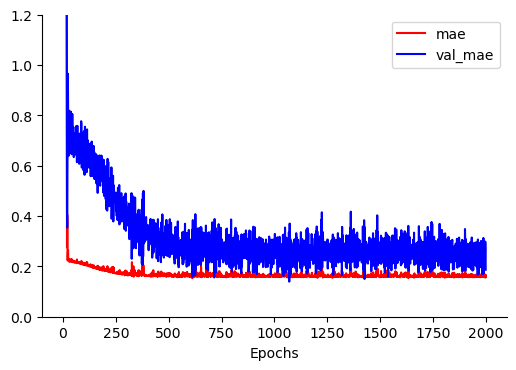

In [76]:
fig = plt.figure(dpi = 100)
plt.plot(history.history['mae'], color='red', label='mae')
plt.plot(history.history['val_mae'], color='blue', label='val_mae')
ax = plt.gca()
ax.set_xlabel('Epochs')
ax.set_ylabel(None)
# ax.set_xlim(150,)
ax.set_ylim(0.,1.2)
# ax.set_yticks([])
ax.set_title(None)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()

#### Predict

In [77]:
model.evaluate(temperature_yearly.drop(['LandAverageTemperature'], axis = 1).to_numpy(), temperature_yearly['LandAverageTemperature'].to_numpy())

6/6 [==============================] - 1s 4ms/step - loss: 0.1708 - mae: 0.1708


[0.17078997194766998, 0.17078997194766998]

In [78]:
model.evaluate(X_valid, y_valid)

1/1 [==============================] - 0s 16ms/step - loss: 0.1869 - mae: 0.1869


[0.18691320717334747, 0.18691320717334747]

### Validation MAE: somewhat better compared to that of 0.1883656435788189 for fixed-partition AR(3) and 0.15548113397624228 for rolling forecast AR(3). But it takes more time to tune and train the model.

In [79]:
prediction = model.predict(temperature_yearly.drop(['LandAverageTemperature'], axis = 1).to_numpy())

In [80]:
prediction_df = pd.Series(prediction.squeeze(), index = temperature_yearly.index)

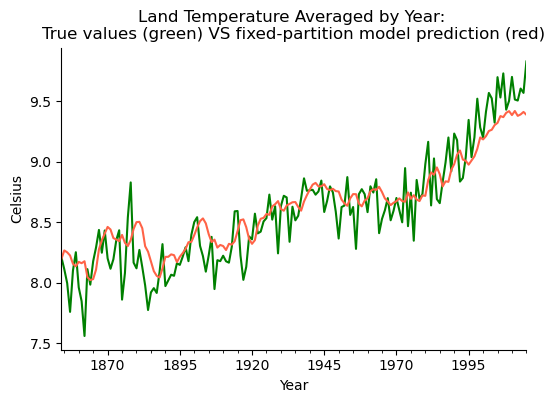

In [81]:
plt.figure(dpi=100)
temperature_yearly['LandAverageTemperature'].plot(ax=plt.gca())
prediction_df.plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('Land Temperature Averaged by Year: \nTrue values (green) VS fixed-partition model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_fixed_partition', dpi=150)

#### LSTM model for the first-differenced series

In [95]:
# tf.keras.backend.clear_session()

model_diff = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
#     Conv1D(filters=64, kernel_size=1, activation='relu'),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
#     tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4), activation = 'relu'),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

In [96]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
lr_decay = PolynomialDecay(initial_learning_rate = 1e-3, decay_steps = 2500, end_learning_rate=1e-4, power = 0.5)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', mode = 'min', patience=3000, min_delta = 0.00001, restore_best_weights=True)

model_diff.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),metrics=["mae"])
history_diff = model_diff.fit(Xdiff_shuffled_train, ydiff_shuffled_train, 
                    validation_data=(Xdiff_valid, ydiff_valid),
                    epochs=2000, callbacks = [callback])

Epoch 1/2000
5/5 [==============================] - 5s 216ms/step - loss: 0.1774 - mae: 0.1774 - val_loss: 0.1890 - val_mae: 0.1890
Epoch 2/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1770 - mae: 0.1770 - val_loss: 0.1883 - val_mae: 0.1883
Epoch 3/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1765 - mae: 0.1765 - val_loss: 0.1880 - val_mae: 0.1880
Epoch 4/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1762 - mae: 0.1762 - val_loss: 0.1874 - val_mae: 0.1874
Epoch 5/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1759 - mae: 0.1759 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 6/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1756 - mae: 0.1756 - val_loss: 0.1866 - val_mae: 0.1866
Epoch 7/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1754 - mae: 0.1754 - val_loss: 0.1861 - val_mae: 0.1861
Epoch 8/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1751 - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1571 - mae: 0.1571 - val_loss: 0.1590 - val_mae: 0.1590
Epoch 64/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1567 - mae: 0.1567 - val_loss: 0.1577 - val_mae: 0.1577
Epoch 65/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1563 - mae: 0.1563 - val_loss: 0.1568 - val_mae: 0.1568
Epoch 66/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1561 - mae: 0.1561 - val_loss: 0.1563 - val_mae: 0.1563
Epoch 67/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1559 - mae: 0.1559 - val_loss: 0.1556 - val_mae: 0.1556
Epoch 68/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1558 - mae: 0.1558 - val_loss: 0.1550 - val_mae: 0.1550
Epoch 69/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1558 - mae: 0.1558 - val_loss: 0.1542 - val_mae: 0.1542
Epoch 70/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1558 - mae: 0.

Epoch 125/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1540 - mae: 0.1540 - val_loss: 0.1532 - val_mae: 0.1532
Epoch 126/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1539 - mae: 0.1539 - val_loss: 0.1535 - val_mae: 0.1535
Epoch 127/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1539 - mae: 0.1539 - val_loss: 0.1538 - val_mae: 0.1538
Epoch 128/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1541 - mae: 0.1541 - val_loss: 0.1541 - val_mae: 0.1541
Epoch 129/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1541 - mae: 0.1541 - val_loss: 0.1541 - val_mae: 0.1541
Epoch 130/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1542 - mae: 0.1542 - val_loss: 0.1540 - val_mae: 0.1540
Epoch 131/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1540 - mae: 0.1540 - val_loss: 0.1537 - val_mae: 0.1537
Epoch 132/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 16ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1532 - val_mae: 0.1532
Epoch 187/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1539 - mae: 0.1539 - val_loss: 0.1535 - val_mae: 0.1535
Epoch 188/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1539 - mae: 0.1539 - val_loss: 0.1533 - val_mae: 0.1533
Epoch 189/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1536 - mae: 0.1536 - val_loss: 0.1529 - val_mae: 0.1529
Epoch 190/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1525 - val_mae: 0.1525
Epoch 191/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1524 - val_mae: 0.1524
Epoch 192/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1523 - val_mae: 0.1523
Epoch 193/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1538 - 

Epoch 248/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1531 - val_mae: 0.1531
Epoch 249/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1530 - val_mae: 0.1530
Epoch 250/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1530 - val_mae: 0.1530
Epoch 251/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1532 - val_mae: 0.1532
Epoch 252/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1533 - val_mae: 0.1533
Epoch 253/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1531 - val_mae: 0.1531
Epoch 254/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1528 - val_mae: 0.1528
Epoch 255/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.1513 - val_mae: 0.1513
Epoch 310/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1515 - val_mae: 0.1515
Epoch 311/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1519 - val_mae: 0.1519
Epoch 312/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1518 - val_mae: 0.1518
Epoch 313/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1515 - val_mae: 0.1515
Epoch 314/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.1515 - val_mae: 0.1515
Epoch 315/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1519 - val_mae: 0.1519
Epoch 316/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1534 - 

Epoch 371/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1497 - val_mae: 0.1497
Epoch 372/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1496 - val_mae: 0.1496
Epoch 373/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1495 - val_mae: 0.1495
Epoch 374/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1493 - val_mae: 0.1493
Epoch 375/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1492 - val_mae: 0.1492
Epoch 376/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.1492 - val_mae: 0.1492
Epoch 377/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1492 - val_mae: 0.1492
Epoch 378/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1531 - mae: 0.1531 - val_loss: 0.1511 - val_mae: 0.1511
Epoch 433/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1531 - mae: 0.1531 - val_loss: 0.1508 - val_mae: 0.1508
Epoch 434/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1506 - val_mae: 0.1506
Epoch 435/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1501 - val_mae: 0.1501
Epoch 436/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1501 - val_mae: 0.1501
Epoch 437/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1504 - val_mae: 0.1504
Epoch 438/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1505 - val_mae: 0.1505
Epoch 439/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - 

Epoch 494/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.1503 - val_mae: 0.1503
Epoch 495/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1531 - mae: 0.1531 - val_loss: 0.1504 - val_mae: 0.1504
Epoch 496/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1505 - val_mae: 0.1505
Epoch 497/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.1506 - val_mae: 0.1506
Epoch 498/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1507 - val_mae: 0.1507
Epoch 499/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1540 - mae: 0.1540 - val_loss: 0.1503 - val_mae: 0.1503
Epoch 500/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.1497 - val_mae: 0.1497
Epoch 501/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.1480 - val_mae: 0.1480
Epoch 556/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.1483 - val_mae: 0.1483
Epoch 557/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1527 - mae: 0.1527 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 558/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1489 - val_mae: 0.1489
Epoch 559/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1495 - val_mae: 0.1495
Epoch 560/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1527 - mae: 0.1527 - val_loss: 0.1497 - val_mae: 0.1497
Epoch 561/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1528 - mae: 0.1528 - val_loss: 0.1500 - val_mae: 0.1500
Epoch 562/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1531 - 

Epoch 617/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1480 - val_mae: 0.1480
Epoch 618/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1477 - val_mae: 0.1477
Epoch 619/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 620/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1476 - val_mae: 0.1476
Epoch 621/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1481 - val_mae: 0.1481
Epoch 622/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1487 - val_mae: 0.1487
Epoch 623/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1526 - mae: 0.1526 - val_loss: 0.1489 - val_mae: 0.1489
Epoch 624/2000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1481 - val_mae: 0.1481
Epoch 679/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 680/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 681/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 682/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 683/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1484 - val_mae: 0.1484
Epoch 684/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1480 - val_mae: 0.1480
Epoch 685/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1522 - 

Epoch 740/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1484 - val_mae: 0.1484
Epoch 741/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 742/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 743/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1487 - val_mae: 0.1487
Epoch 744/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1488 - val_mae: 0.1488
Epoch 745/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 746/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1484 - val_mae: 0.1484
Epoch 747/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1457 - val_mae: 0.1457
Epoch 802/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1523 - mae: 0.1523 - val_loss: 0.1461 - val_mae: 0.1461
Epoch 803/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1461 - val_mae: 0.1461
Epoch 804/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 805/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 806/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1460 - val_mae: 0.1460
Epoch 807/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1458 - val_mae: 0.1458
Epoch 808/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1521 - 

Epoch 863/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1481 - val_mae: 0.1481
Epoch 864/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 865/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 866/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1487 - val_mae: 0.1487
Epoch 867/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 868/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1520 - mae: 0.1520 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 869/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1520 - mae: 0.1520 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 870/2000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 925/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 926/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1478 - val_mae: 0.1478
Epoch 927/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1477 - val_mae: 0.1477
Epoch 928/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1477 - val_mae: 0.1477
Epoch 929/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1476 - val_mae: 0.1476
Epoch 930/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 931/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1516 - 

Epoch 986/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1469 - val_mae: 0.1469
Epoch 987/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1516 - mae: 0.1516 - val_loss: 0.1471 - val_mae: 0.1471
Epoch 988/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.1476 - val_mae: 0.1476
Epoch 989/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.1480 - val_mae: 0.1480
Epoch 990/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 991/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.1476 - val_mae: 0.1476
Epoch 992/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.1471 - val_mae: 0.1471
Epoch 993/2000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1460 - val_mae: 0.1460
Epoch 1048/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1461 - val_mae: 0.1461
Epoch 1049/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1466 - val_mae: 0.1466
Epoch 1050/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1468 - val_mae: 0.1468
Epoch 1051/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1470 - val_mae: 0.1470
Epoch 1052/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 1053/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1464 - val_mae: 0.1464
Epoch 1054/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1512 - mae: 0.1512 - val_loss: 0.1442 - val_mae: 0.1442
Epoch 1109/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1512 - mae: 0.1512 - val_loss: 0.1439 - val_mae: 0.1439
Epoch 1110/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1437 - val_mae: 0.1437
Epoch 1111/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1438 - val_mae: 0.1438
Epoch 1112/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.1515 - mae: 0.1515 - val_loss: 0.1442 - val_mae: 0.1442
Epoch 1113/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1443 - val_mae: 0.1443
Epoch 1114/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1513 - mae: 0.1513 - val_loss: 0.1443 - val_mae: 0.1443
Epoch 1115/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1434 - val_mae: 0.1434
Epoch 1170/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1435 - val_mae: 0.1435
Epoch 1171/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1438 - val_mae: 0.1438
Epoch 1172/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1440 - val_mae: 0.1440
Epoch 1173/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.1443 - val_mae: 0.1443
Epoch 1174/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 1175/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1444 - val_mae: 0.1444
Epoch 1176/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.

Epoch 1230/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1508 - mae: 0.1508 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 1231/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1447 - val_mae: 0.1447
Epoch 1232/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1446 - val_mae: 0.1446
Epoch 1233/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1508 - mae: 0.1508 - val_loss: 0.1447 - val_mae: 0.1447
Epoch 1234/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1508 - mae: 0.1508 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 1235/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1447 - val_mae: 0.1447
Epoch 1236/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1452 - val_mae: 0.1452
Epoch 1237/2000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 0.1510 - mae: 0.1510 - val_loss: 0.1440 - val_mae: 0.1440
Epoch 1292/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.1438 - val_mae: 0.1438
Epoch 1293/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1510 - mae: 0.1510 - val_loss: 0.1434 - val_mae: 0.1434
Epoch 1294/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1431 - val_mae: 0.1431
Epoch 1295/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1430 - val_mae: 0.1430
Epoch 1296/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1506 - mae: 0.1506 - val_loss: 0.1428 - val_mae: 0.1428
Epoch 1297/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1425 - val_mae: 0.1425
Epoch 1298/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 12ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1456 - val_mae: 0.1456
Epoch 1353/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1508 - mae: 0.1508 - val_loss: 0.1453 - val_mae: 0.1453
Epoch 1354/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1450 - val_mae: 0.1450
Epoch 1355/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1506 - mae: 0.1506 - val_loss: 0.1451 - val_mae: 0.1451
Epoch 1356/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1453 - val_mae: 0.1453
Epoch 1357/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.1453 - val_mae: 0.1453
Epoch 1358/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.1454 - val_mae: 0.1454
Epoch 1359/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1506 - mae: 0.1506 - val_loss: 0.1432 - val_mae: 0.1432
Epoch 1414/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1506 - mae: 0.1506 - val_loss: 0.1428 - val_mae: 0.1428
Epoch 1415/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1424 - val_mae: 0.1424
Epoch 1416/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1420 - val_mae: 0.1420
Epoch 1417/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1419 - val_mae: 0.1419
Epoch 1418/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1505 - mae: 0.1505 - val_loss: 0.1418 - val_mae: 0.1418
Epoch 1419/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1418 - val_mae: 0.1418
Epoch 1420/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.

5/5 [==============================] - 0s 10ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 1475/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1502 - mae: 0.1502 - val_loss: 0.1460 - val_mae: 0.1460
Epoch 1476/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1501 - mae: 0.1501 - val_loss: 0.1457 - val_mae: 0.1457
Epoch 1477/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1500 - mae: 0.1500 - val_loss: 0.1455 - val_mae: 0.1455
Epoch 1478/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1501 - mae: 0.1501 - val_loss: 0.1455 - val_mae: 0.1455
Epoch 1479/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1501 - mae: 0.1501 - val_loss: 0.1455 - val_mae: 0.1455
Epoch 1480/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1500 - mae: 0.1500 - val_loss: 0.1457 - val_mae: 0.1457
Epoch 1481/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1499 - mae: 0.1499 - val_loss: 0.1442 - val_mae: 0.1442
Epoch 1536/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1499 - mae: 0.1499 - val_loss: 0.1444 - val_mae: 0.1444
Epoch 1537/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1500 - mae: 0.1500 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 1538/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1499 - mae: 0.1499 - val_loss: 0.1444 - val_mae: 0.1444
Epoch 1539/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1499 - mae: 0.1499 - val_loss: 0.1443 - val_mae: 0.1443
Epoch 1540/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1498 - mae: 0.1498 - val_loss: 0.1440 - val_mae: 0.1440
Epoch 1541/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1498 - mae: 0.1498 - val_loss: 0.1437 - val_mae: 0.1437
Epoch 1542/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1496 - mae: 0.1496 - val_loss: 0.1464 - val_mae: 0.1464
Epoch 1597/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1496 - mae: 0.1496 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 1598/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1496 - mae: 0.1496 - val_loss: 0.1471 - val_mae: 0.1471
Epoch 1599/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1500 - mae: 0.1500 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 1600/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1503 - mae: 0.1503 - val_loss: 0.1479 - val_mae: 0.1479
Epoch 1601/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1507 - mae: 0.1507 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 1602/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 1603/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 10ms/step - loss: 0.1494 - mae: 0.1494 - val_loss: 0.1456 - val_mae: 0.1456
Epoch 1658/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.1456 - val_mae: 0.1456
Epoch 1659/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.1454 - val_mae: 0.1454
Epoch 1660/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1496 - mae: 0.1496 - val_loss: 0.1453 - val_mae: 0.1453
Epoch 1661/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.1455 - val_mae: 0.1455
Epoch 1662/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 1663/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1494 - mae: 0.1494 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 1664/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 15ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.1430 - val_mae: 0.1430
Epoch 1719/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1491 - mae: 0.1491 - val_loss: 0.1429 - val_mae: 0.1429
Epoch 1720/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.1430 - val_mae: 0.1430
Epoch 1721/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.1434 - val_mae: 0.1434
Epoch 1722/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.1436 - val_mae: 0.1436
Epoch 1723/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.1437 - val_mae: 0.1437
Epoch 1724/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.1435 - val_mae: 0.1435
Epoch 1725/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 14ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.1447 - val_mae: 0.1447
Epoch 1780/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.1446 - val_mae: 0.1446
Epoch 1781/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.1449 - val_mae: 0.1449
Epoch 1782/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.1454 - val_mae: 0.1454
Epoch 1783/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1456 - val_mae: 0.1456
Epoch 1784/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1457 - val_mae: 0.1457
Epoch 1785/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1458 - val_mae: 0.1458
Epoch 1786/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 1841/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1464 - val_mae: 0.1464
Epoch 1842/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.1465 - val_mae: 0.1465
Epoch 1843/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1484 - mae: 0.1484 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 1844/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1487 - mae: 0.1487 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 1845/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1489 - mae: 0.1489 - val_loss: 0.1470 - val_mae: 0.1470
Epoch 1846/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.1470 - val_mae: 0.1470
Epoch 1847/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.

5/5 [==============================] - 0s 11ms/step - loss: 0.1484 - mae: 0.1484 - val_loss: 0.1461 - val_mae: 0.1461
Epoch 1902/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.1460 - val_mae: 0.1460
Epoch 1903/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 1904/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1484 - mae: 0.1484 - val_loss: 0.1459 - val_mae: 0.1459
Epoch 1905/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1483 - mae: 0.1483 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 1906/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1483 - mae: 0.1483 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 1907/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1483 - mae: 0.1483 - val_loss: 0.1471 - val_mae: 0.1471
Epoch 1908/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.

5/5 [==============================] - 0s 15ms/step - loss: 0.1482 - mae: 0.1482 - val_loss: 0.1476 - val_mae: 0.1476
Epoch 1963/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.1482 - mae: 0.1482 - val_loss: 0.1482 - val_mae: 0.1482
Epoch 1964/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1481 - mae: 0.1481 - val_loss: 0.1486 - val_mae: 0.1486
Epoch 1965/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.1488 - val_mae: 0.1488
Epoch 1966/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1487 - mae: 0.1487 - val_loss: 0.1490 - val_mae: 0.1490
Epoch 1967/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1487 - val_mae: 0.1487
Epoch 1968/2000
5/5 [==============================] - 0s 16ms/step - loss: 0.1484 - mae: 0.1484 - val_loss: 0.1481 - val_mae: 0.1481
Epoch 1969/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.

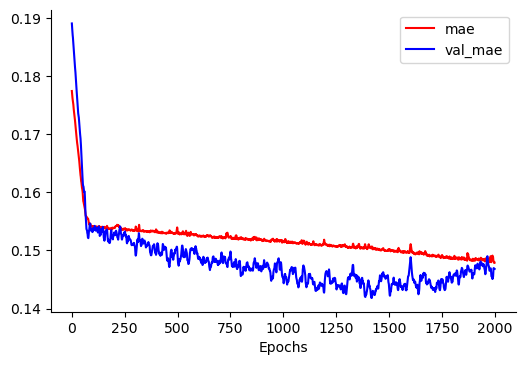

In [97]:
fig = plt.figure(dpi = 100)
plt.plot(history_diff.history['mae'], color='red', label='mae')
plt.plot(history_diff.history['val_mae'], color='blue', label='val_mae')
ax = plt.gca()
ax.set_xlabel('Epochs')
ax.set_ylabel(None)
# ax.set_xlim(150,)
# ax.set_ylim(0.,.2)
# ax.set_yticks([])
ax.set_title(None)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()

#### Predict

In [99]:
model_diff.evaluate(temperature_yearly_diff.drop(['LandAverageTemperature'], axis = 1).to_numpy(), temperature_yearly_diff['LandAverageTemperature'].to_numpy())

6/6 [==============================] - 1s 4ms/step - loss: 0.1477 - mae: 0.1477


[0.147746279835701, 0.147746279835701]

In [100]:
model_diff.evaluate(Xdiff_valid, ydiff_valid)

1/1 [==============================] - 0s 15ms/step - loss: 0.1468 - mae: 0.1468


[0.1468219757080078, 0.1468219757080078]

### Validation MAE: better compared to that of 0.18691320717334747 for the non-differenced fixed-partition LSTM,  0.1883656435788189 for fixed-partition differenced AR(3) and 0.15548113397624228 for rolling forecast differenced AR(3). But it takes more time to train the model.

In [103]:
prediction_diff = model_diff.predict(temperature_yearly_diff.drop(['LandAverageTemperature'], axis = 1).to_numpy()).squeeze()

In [114]:
"""add the true time series to the first difference"""
prediction_diff_add = []
for i in range(len(prediction_diff)):
    prediction_diff_add.append(prediction_diff[i] + temperature_yearly['LandAverageTemperature'].iloc[i])

In [118]:
prediction_diff_add = pd.Series(prediction_diff_add, index = temperature_yearly_diff.index)

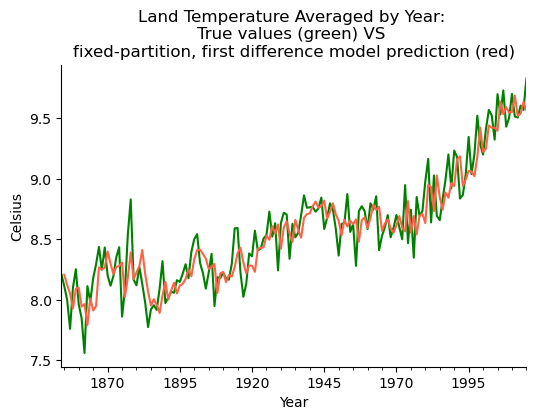

In [121]:
plt.figure(dpi=100)
temperature_yearly['LandAverageTemperature'].plot(ax=plt.gca())
prediction_diff_add.plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('Land Temperature Averaged by Year: \nTrue values (green) VS \nfixed-partition, first difference model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_fixed_partition', dpi=150)

In [122]:
from sklearn.metrics import mean_absolute_error

In [124]:
mean_absolute_error(temperature_yearly['LandAverageTemperature'].iloc[1:], prediction_diff_add)

0.14774628531187006

## Rolling forecast

#### To mimick real-world deployment, we perform rolling forecast on the first difference. The first split is again at 1986-12-31. At each time step, we use as training set the ground truth from the previous time steps, which is re-shuffled to eliminate sequence bias. The training set is used to fit an LSTM model which has the same architecture as model_diff used above in fixed partitioning. Without using a validation set (which would involve peeking into future data) during model training, we train it for 1500 epochs; that is the ballpark which the fixed-partitioning model reached the lowest validation MAE. 

In [134]:
# split_time = pd.Timestamp(1986,6,30)
temperature_yearly_diff.index[131]

Timestamp('1986-12-31 00:00:00', freq='A-DEC')

In [176]:
from tqdm import tqdm    # fancy progress bar for the for-loop
size = 131

# ground truth (first difference and lags) from past time steps
history_diff_rolling = temperature_yearly_diff_train.to_numpy().copy()
# ground truth (first difference and lags) at present/future time steps
diff_rolling_valid = temperature_yearly_diff_valid
# rolling forecast predictions
rolling_forecast_first_diff1 = []
# LSTM model history at each time step
historiesLSTM = []

# for t in range(1):
for t in tqdm(range(len(temperature_yearly_diff_valid))):
    # re-shuffle training set to avoid sequence bias
    np.random.seed(0)
    np.random.shuffle(history_diff_rolling)
    Xdiff_roll_shuffled_train, ydiff_roll_shuffled_train = history_diff_rolling[:,1:], history_diff_rolling[:,0]
    
    # define LSTM model
    model_diff_roll = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])
    model_diff_roll.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),metrics=["mae"])
    # train on training set, without using a validation set to avoid data leakage
    history_LSTM = model_diff_roll.fit(Xdiff_roll_shuffled_train, ydiff_roll_shuffled_train,
                    epochs=1500, verbose=0)
    historiesLSTM.append(history_LSTM)
    # forecast one time step ahead
    output = model_diff.predict(np.expand_dims(diff_rolling_valid.drop(['LandAverageTemperature'], axis = 1).iloc[0].to_numpy(), axis = 0)).squeeze().item()
    rolling_forecast_first_diff1.append(output)
    
    # update the training set by including data from the present time step for the forecast the next time step
    history_diff_rolling = np.vstack([history_diff_rolling, np.expand_dims(diff_rolling_valid.iloc[0].to_numpy(), axis=0)])
    diff_rolling_valid = diff_rolling_valid.iloc[1:]
    

100%|██████████| 30/30 [27:20<00:00, 54.69s/it]


In [177]:
rolling_forecast_first_diff1

[0.08573034405708313,
 0.05274385213851929,
 -0.15096458792686462,
 -0.23625636100769043,
 0.018153468146920204,
 -0.07122654467821121,
 0.005400834605097771,
 0.10428426414728165,
 0.1290794163942337,
 0.02759922854602337,
 -0.2864695191383362,
 -0.017439154908061028,
 -0.021508587524294853,
 -0.09892455488443375,
 -0.061148397624492645,
 0.048556938767433167,
 0.027062105014920235,
 -0.14767062664031982,
 -0.10098777711391449,
 0.07293521612882614,
 -0.062044400721788406,
 0.00256302859634161,
 -0.13827089965343475,
 0.11672736704349518,
 0.04756740480661392,
 -0.013416983187198639,
 0.004878432955592871,
 0.03313745558261871,
 0.030548904091119766,
 -0.0036572820972651243]

#### Predict

In [185]:
"""add the true time series to the first difference"""
prediction_diff_add_roll = []
for i in range(len(rolling_forecast_first_diff1)):
    if i == 0:
        prediction_diff_add_roll.append(rolling_forecast_first_diff1[0] + temperature_yearly_train['LandAverageTemperature'].iloc[-1])
    else:
        prediction_diff_add_roll.append(rolling_forecast_first_diff1[i] + temperature_yearly_valid['LandAverageTemperature'].iloc[i-1])

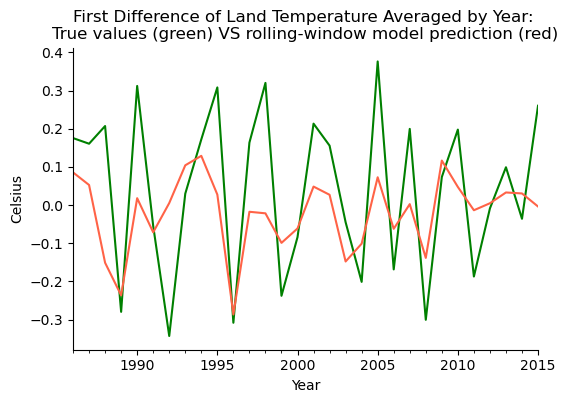

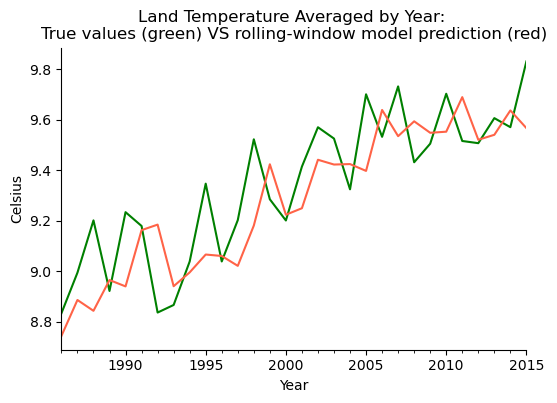

In [186]:
plt.figure(dpi=100)
temperature_yearly_diff_valid['LandAverageTemperature'].plot(ax=plt.gca())
pd.Series(rolling_forecast_first_diff1, index = temperature_yearly_diff_valid.index).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('First Difference of Land Temperature Averaged by Year: \nTrue values (green) VS rolling-window model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plt.savefig(r'plots/LandAverageTemperature_year_AR3_rolling_forecast_first_diff', dpi=150)


plt.figure(dpi=100)
temperature_yearly_valid['LandAverageTemperature'].plot(ax=plt.gca())
pd.Series(prediction_diff_add_roll, index = temperature_yearly_valid.index).plot(ax=plt.gca())
ax1 = plt.gca()
ax1.get_lines()[0].set_color("green")
ax1.get_lines()[1].set_color("tomato")
plt.title('Land Temperature Averaged by Year: \nTrue values (green) VS rolling-window model prediction (red)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Celsius')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#### MAE

In [192]:
mean_absolute_error(temperature_yearly_valid['LandAverageTemperature'], pd.Series(prediction_diff_add_roll, index = temperature_yearly_valid.index))

0.14682197450355955

### Naive Forecast (lag 1)

In [212]:
temperature_yearly_naive = [np.nan] + temperature_yearly['LandAverageTemperature'].to_list()[:-1]

In [213]:
mean_absolute_error(temperature_yearly_valid['LandAverageTemperature'], pd.Series(temperature_yearly_naive[-30:], index = temperature_yearly_valid.index))

0.18930555555555575

## Summary of Results

Validation (data from 1986 onward) MAE:<br>
Naive forecast (lag 1): 0.18930555555555575<br>
AR(3) fixed partitioning: 0.1883656435788189<br>
AR(3) rolling forecast: 0.15548113397624228

LSTM, without differencing, fixed partitioning: 0.18691320717334747<br>
LSTM, with differencing, fixed partitioning: 0.1468219757080078<br>

LSTM, with differencing, rolling forecast: 0.14682197450355955